In [2]:
ls

sample_data/  solution2.ipynb  solution.ipynb  tic_env.py  tic_tac_toe.ipynb


## Functions

In [20]:
def whose_grid(g, player):
    '''
    g is a grid matrix of 3 x 3
    player : X for me, O for oppenent
    '''
    if player == 'X':
        color = 1
    else:
        color = -1

    res = torch.zeros(g.shape)
    for x in range(g.shape[0]):
        for y in range(g.shape[1]):
            if g[x][y] == color:
                res[x][y] = color
            else:
                res[x][y] = 0

    return res
    

In [21]:
def a_to_pos(a):
    '''
    a : int [0,8]
    '''
    if a < 3:
        return (0,a)
    elif a < 6:
        return (1, a-3)
    else:
        return (2, a-6)

## Class DQN


In [106]:
# Second Part
import torch
import torch.nn as nn
import torch.nn.functional as F

N_STATES = 18
N_ACTIONS = 9
MEMORY_CAPACITY = 10000
TARGET_REPLACE_ITER = 500
BATCH_SIZE = 64
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(N_STATES, 128)
        self.layer1.weight.data.normal_(0, 0.1)
        self.layer2 = nn.Linear(128, 128)
        self.layer2.weight.data.normal_(0, 0.1)
        self.out = nn.Linear(128, N_ACTIONS)
        self.out.weight.data.normal_(0, 0.1)

    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.out(x)
        # x = F.softmax(x, dim=1)
        return x


class DQN(object):
    def __init__(self, epsilon=0.2, player='X', lr=5e-4, decay=0.99):
        self.eval_net, self.target_net = Net(), Net()
        self.epsilon = epsilon
        self.lr = lr
        self.decay = decay
        self.player = player

        self.learn_step_counter = 0                                     # for target updating
        self.memory_counter = 0                                         # for storing memory
        self.memory = torch.zeros((MEMORY_CAPACITY, N_STATES*2 + 2))     # initialize memory
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=lr)
        self.loss_func = nn.SmoothL1Loss()
        self.loss_250 = 0
        self.loss = []
        self.training = True

    def train(self): # train mode
        self.training = True
    
    def act(self, grid, **kwargs):
        '''
        grid : grid tensor with shape 3x3
        player : to indicate player is 'X' or 'O'
        '''
        player = kwargs['player']
        # Change grid to state tensor
        grid_mine = whose_grid(grid, player)
        grid_opp = whose_grid(grid, player)
        x = torch.stack((grid_mine, grid_opp), axis=0)

        # x : [1,18]
        x = x.view(1, -1)
        # input only one sample
        if np.random.uniform() > self.epsilon:   # greedy
            actions_value = self.eval_net.forward(x)
            # print("actions_value")
            # print(actions_value)
            action = int(actions_value.argmax())
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
        assert action < 9 and action >-1
        return action

    def store_transition(self, s, a, r, s_):
        '''
        s : The state of this round
        a : The action taken of this round
        r : The reward got of this round
        s_ : The state of next round
        '''
        # s and s_ shape [1, 18]
        s = s.view(1, -1)
        s_ = s_.view(1, -1)
        # a_r shape [1,2]
        a_r = torch.Tensor([a, r]).view(1, -1)
        #transition shape [1, 36]
        transition = torch.hstack((s, a_r, s_))
        # replace the old memory with new memory
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        if self.memory_counter > MEMORY_CAPACITY:
            # target parameter update
            if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
                self.target_net.load_state_dict(self.eval_net.state_dict())
            self.learn_step_counter += 1

            # sample batch transitions
            sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
            b_memory = self.memory[sample_index, :]
            # print("mm")
            # print(self.memory[-1,:])
            b_s = torch.Tensor(b_memory[:, :N_STATES])
            b_a = torch.LongTensor(b_memory[:, N_STATES:N_STATES+1].long())
            b_r = torch.Tensor(b_memory[:, N_STATES+1:N_STATES+2])
            b_s_ = torch.Tensor(b_memory[:, -N_STATES:])
            #b_s_ shape: [64, 18]

            # q_eval w.r.t the action in experience
            q_eval = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
            q_next = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate

            q_target = torch.zeros(b_r.shape)
            max_q = self.decay * q_next.max(1)[0].view(BATCH_SIZE, 1)
            for i in range(b_r.shape[0]):
                for j in range(b_r.shape[1]):
                    # whether terminal state
                    if b_r[i][j] == 1 or b_r[i][j] == -1:
                        q_target[i][j] = b_r[i][j]
                    else:
                        q_target[i][j] = b_r[i][j] + max_q[i][j] 
            # print("br")
            # print(b_r.shape)
            # q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)   # shape (batch, 1)
            loss = self.loss_func(q_eval, q_target)

            # Calculate reward and training loss
            if self.memory_counter % 250 == 0:
                self.loss.append(self.loss_250 / 250.)
                self.loss_250 = 0
            else:
                self.loss_250 += loss.item()
            
        
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        else:
            pass

In [91]:
import numpy as np
import random
from copy import deepcopy

class TictactoeEnv:
    '''
    Description:
        Classical Tic-tac-toe game for two players who take turns marking the spaces in a three-by-three grid with X or O.
        The player who succeeds in placing three of their marks in a horizontal, vertical, or diagonal row is the winner.

        The game is played by two players: player 'X' and player 'O'. Player 'x' moves first.

        The grid is represented by a 3x3 numpy array, with value in {0, 1, -1}, with corresponding values:
            0 - place unmarked
            1 - place marked with X
            -1 - place marked with O

        The game environment will recieve movement from two players in turn and update the grid.

    self.step:
        recieve the movement of the player, update the grid

    The action space is [0-8], representing the 9 positions on the grid.

    The reward is 1 if you win the game, -1 if you lose, and 0 besides.
    '''

    def __init__(self):
        self.grid = np.zeros((3,3))
        self.end = False
        self.winner = None
        self.player2value = {'X': 1, 'O': -1}
        self.num_step = 0
        self.current_player = 'X' # By default, player 'X' goes first

    def check_valid(self, position):
        ''' Check whether the current action is valid or not
        '''
        if self.end:
            raise ValueError('This game has ended, please reset it!')
        if type(position) is int:
            position = (int(position / 3), position % 3)
        elif type(position) is not tuple:
            position = tuple(position)

        return False if self.grid[position] != 0 else True

    def step(self, position, print_grid=False):
        ''' Receive the movement from two players in turn and update the grid
        '''
        # check the position and value are valid or not
        # position should be a tuple like (0, 1) or int [0-8]
        if self.end:
            raise ValueError('This game has ended, please reset it!')
        if type(position) is int:
            position = (int(position / 3), position % 3)
        elif type(position) is not tuple:
            position = tuple(position)
        if self.grid[position] != 0:
            raise ValueError('There is already a chess on position {}.'.format(position))

        # place a chess on the position
        self.grid[position] = self.player2value[self.current_player]
        # update
        self.num_step += 1
        self.current_player = 'X' if self.num_step % 2 == 0 else  'O'
        # check whether the game ends or not
        self.checkEnd()

        if print_grid:
            self.render()

        return self.grid.copy(), self.end, self.winner

    def get_current_player(self):
        return self.current_player

    def checkEnd(self):
        # check rows and cols
        if np.any(np.sum(self.grid, axis=0) == 3) or np.any(np.sum(self.grid, axis=1) == 3):
            self.end = True
            self.winner = 'X'
        elif np.any(np.sum(self.grid, axis=0) == -3) or np.any(np.sum(self.grid, axis=1) == -3):
            self.end = True
            self.winner = 'O'
        # check diagnols
        elif self.grid[[0,1,2],[0,1,2]].sum() == 3 or self.grid[[0,1,2],[2,1,0]].sum() == 3:
            self.end = True
            self.winner = 'X'
        elif self.grid[[0,1,2],[0,1,2]].sum() == -3 or self.grid[[0,1,2],[2,1,0]].sum() == -3:
            self.end = True
            self.winner = 'O'
        # check if all the positions are filled
        elif (self.grid == 0).sum() == 0:
            self.end = True
            self.winner = None # no one wins
        else:
            self.end = False
            self.winner = None

    def reset(self):
        # reset the grid
        self.grid = np.zeros((3,3))
        self.end = False
        self.winner = None
        self.num_step = 0
        self.current_player = 'X'

        return self.grid.copy(), self.end, self.winner

    def observe(self):
        return self.grid.copy(), self.end, self.winner

    def reward(self, player='X'):
        if self.end:
            if self.winner is None:
                return 0
            else:
                return 1 if player == self.winner else -1
        else:
            return 0

    def render(self):
        # print current grid
        value2player = {0: '-', 1: 'X', -1: 'O'}
        for i in range(3):
            print('|', end='')
            for j in range(3):
                print(value2player[int(self.grid[i,j])], end=' ' if j<2 else '')
            print('|')
        print()

class OptimalPlayer:
    '''
    Description:
        A class to implement an epsilon-greedy optimal player in Tic-tac-toe.

    About optimial policy:
        There exists an optimial policy for game Tic-tac-toe. A player ('X' or 'O') can win or at least draw with optimial strategy.
        See the wikipedia page for details https://en.wikipedia.org/wiki/Tic-tac-toe
        In short, an optimal player choose the first available move from the following list:
            [Win, BlockWin, Fork, BlockFork, Center, Corner, Side]

    Parameters:
        epsilon: float, in [0, 1]. This is a value between 0-1 that indicates the
            probability of making a random action instead of the optimal action
            at any given time.

    '''
    def __init__(self, epsilon=0.2, player='X'):
        self.epsilon = epsilon
        self.player = player # 'x' or 'O'

    def set_player(self, player = 'X', j=-1):
        self.player = player
        if j != -1:
            self.player = 'X' if j % 2 == 0 else 'O'

    def empty(self, grid):
        '''return all empty positions'''
        avail = []
        for i in range(9):
            pos = (int(i/3), i % 3)
            if grid[pos] == 0:
                avail.append(pos)
        return avail

    def center(self, grid):
        '''
        Pick the center if its available,
        if it's the first step of the game, center or corner are all optimial.
        '''
        if np.abs(grid).sum() == 0:
            # first step of the game
            return [(1, 1)] + self.corner(grid)

        return [(1, 1)] if grid[1, 1] == 0 else []

    def corner(self, grid):
        ''' Pick empty corners to move '''
        corner = [(0, 0), (0, 2), (2, 0), (2, 2)]
        cn = []
        # First, pick opposite corner of opponent if it's available
        for i in range(4):
            if grid[corner[i]] == 0 and grid[corner[3 - i]] != 0:
                cn.append(corner[i])
        if cn != []:
            return cn
        else:
            for idx in corner:
                if grid[idx] == 0:
                    cn.append(idx)
            return cn

    def side(self, grid):
        ''' Pick empty sides to move'''
        rt = []
        for idx in [(0, 1), (1, 0), (1, 2), (2, 1)]:
            if grid[idx] == 0:
                rt.append(idx)
        return rt

    def win(self, grid, val=None):
        ''' Pick all positions that player will win after taking it'''
        if val is None:
            val = 1 if self.player == 'X' else -1

        towin = []
        # check all positions
        for pos in self.empty(grid):
            grid_ = np.copy(grid)
            grid_[pos] = val
            if self.checkWin(grid_, val):
                towin.append(pos)

        return towin

    def blockWin(self, grid):
        ''' Find the win positions of opponent and block it'''
        oppon_val = -1 if self.player == 'X' else 1
        return self.win(grid, oppon_val)

    def fork(self, grid, val=None):
        ''' Find a fork opportunity that the player will have two positions to win'''
        if val is None:
            val = 1 if self.player == 'X' else -1

        tofork = []
        # check all positions
        for pos in self.empty(grid):
            grid_ = np.copy(grid)
            grid_[pos] = val
            if self.checkFork(grid_, val):
                tofork.append(pos)

        return tofork

    def blockFork(self, grid):
        ''' Block the opponent's fork.
            If there is only one possible fork from opponent, block it.
            Otherwise, player should force opponent to block win by making two in a row or column
            Amomg all possible force win positions, choose positions in opponent's fork in prior
        '''
        oppon_val = -1 if self.player == 'X' else 1
        oppon_fork = self.fork(grid, oppon_val)
        if len(oppon_fork) <= 1:
            return oppon_fork

        # force the opponent to block win
        force_blockwin = []
        val = 1 if self.player == 'X' else -1
        for pos in self.empty(grid):
            grid_ = np.copy(grid)
            grid_[pos] = val
            if np.any(np.sum(grid_, axis=0) == val*2) or np.any(np.sum(grid_, axis=1) == val*2):
                force_blockwin.append(pos)
        force_blockwin_prior = []
        for pos in force_blockwin:
            if pos in oppon_fork:
                force_blockwin_prior.append(pos)

        return force_blockwin_prior if force_blockwin_prior != [] else force_blockwin

    def checkWin(self, grid, val=None):
        # check whether the player corresponding to the val will win
        if val is None:
            val = 1 if self.player == 'X' else -1
        target = 3 * val
        # check rows and cols
        if np.any(np.sum(grid, axis=0) == target) or np.any(np.sum(grid, axis=1) == target):
            return True
        # check diagnols
        elif grid[[0,1,2],[0,1,2]].sum() == target or grid[[0,1,2],[2,1,0]].sum() == target:
            return True
        else:
            return False

    def checkFork(self, grid, val=None):
        # check whether the player corresponding to the val will fork
        if val is None:
            val = 1 if self.player == 'X' else -1
        target = 2 * val
        # check rows and cols
        rows = (np.sum(grid, axis=0) == target).sum()
        cols = (np.sum(grid, axis=1) == target).sum()
        diags = (grid[[0,1,2],[0,1,2]].sum() == target) + (grid[[0,1,2],[2,1,0]].sum() == target)
        if (rows + cols + diags) >= 2:
            return True
        else:
            return False

    def randomMove(self, grid):
        """ Chose a random move from the available options. """
        avail = self.empty(grid)

        return avail[random.randint(0, len(avail)-1)]

    def act(self, grid, **kwargs):
        """
        Goes through a hierarchy of moves, making the best move that
        is currently available each time (with probabitity 1-self.epsilon).
        A touple is returned that represents (row, col).
        """
        # whether move in random or not
        if random.random() < self.epsilon:
            return self.randomMove(grid)

        ### optimial policies

        # Win
        win = self.win(grid)
        if win != []:
            return win[random.randint(0, len(win)-1)]
        # Block win
        block_win = self.blockWin(grid)
        if block_win != []:
            return block_win[random.randint(0, len(block_win)-1)]
        # Fork
        fork = self.fork(grid)
        if fork != []:
            return fork[random.randint(0, len(fork)-1)]
        # Block fork
        block_fork = self.blockFork(grid)
        if block_fork != []:
            return block_fork[random.randint(0, len(block_fork)-1)]
        # Center
        center = self.center(grid)
        if center != []:
            return center[random.randint(0, len(center)-1)]
        # Corner
        corner = self.corner(grid)
        if corner != []:
            return corner[random.randint(0, len(corner)-1)]
        # Side
        side = self.side(grid)
        if side != []:
            return side[random.randint(0, len(side)-1)]

        # random move
        return self.randomMove(grid)
    
    def toState(self, grid):
        "Convert a grid to a state in tuple format as key"
        return tuple([int(x) for x in np.ravel(grid)])

    # we add the following empty method to accomodate QPlayer

    def add(self, grid, move):
        pass
    
    def store_transition(self, s_t, move, r, s_next):
        pass

    def backprop(self, reward, Q):
        pass

    def learn(self):
        pass    

    def reset(self):
        pass

    def decay_eps(self, epoch, epoch_star=1):
        pass

    def train(self):
        pass

    def eval(self):
        pass

## DQN Learning

In [107]:
from collections import defaultdict
class DQlearningEnv(TictactoeEnv):
    def __init__(self, player1: OptimalPlayer, player2: OptimalPlayer, Q=None):
        super(DQlearningEnv, self).__init__()
        self.player1 = player1 # player X at the each game
        self.player2 = player2 # player O at the each game
        self.training_reward_list = defaultdict(list) # see record_reward(self)
        self.test_reward_list = defaultdict(list) # see record_reward(self)
        self.training_loss_list = defaultdict(list)
        self.test_avg_reward = defaultdict(list)
        self.decay_eps = False # whether decay epsilon
        self.testing = False 
        self.s_terminal = torch.ones((2,3,3))
        self.loss = 0

        self.dict_p1 = {'player' : self.player1.player} 
        self.dict_p2 = {'player' : self.player2.player} 
        # if Q is None:
        #     Q = defaultdict(lambda: defaultdict(int))
        # self.Q = {'Q': Q} # we use a dict here to match act method in OptimalPlayer.
    def backprop(self):
        # backpropagate reward to update Q. 
        # if self.winner == 'X':
        #     self.player1.learn()
        #     self.player2.learn()
        # elif self.winner == 'O':
        #     self.player1.learn()
        #     self.player2.learn()
        #     pass
        # else:
        #     self.player1.learn()
        #     self.player2.learn()
        self.player1.learn()
        self.player2.learn()

    def reset_all(self):
        # reset env by clearing game board and empty player's history
        # but do not modify player's Q function.
        self.reset()
        # self.player1.reset()
        # self.player2.reset()

    def set_decay_eps(self, epoch_star=1):
        # enable decaying epsilon
        self.decay_eps = True
        self.epoch_star = epoch_star # n* in the paper
    
    def set_testing(self, test_eps=0, test_per_epoch=250):
        # enable test every test_per_epoch
        self.testing = True
        self.test_per_epoch = test_per_epoch
        self.test_player = None
        self.test_eps = test_eps

    def record_reward(self, training=True):
        # we always record reward for player 'X' at self.training_reward_list['X']
        # and record for player 'O' at self.training_reward_list['O'].
        #  No matter which player we are training. 
        # Similarly for self.test_reward_list
        if training:
            reward_list = self.training_reward_list
            # loss_list = self.training_loss_list
        else:
            reward_list = self.test_reward_list
        if self.winner == 'X':
            reward_list['X'].append(1)
            reward_list['O'].append(-1)
        elif self.winner == 'O':
            reward_list['X'].append(-1)
            reward_list['O'].append(1)
        else:
            reward_list['X'].append(0)
            reward_list['O'].append(0)
        
        # loss_list.append(self.loss)
    
    def get_reward(self, player=1, training=True):
        # player=1 if we want to get reward from the 1st player while input
        # player=2 if 2nd
        # since we switch the player after each game, the 1st player will get all odd position 
        # from ['X'] and even position from ['O']. 
        def connect_lst(list1, list2):
            result = [None]*(len(list1)+len(list2))
            result[::2] = list1
            result[1::2] = list2
            return result

        if training:
            reward_list = self.training_reward_list
        else:
            reward_list = self.test_reward_list

        if player==1:
            return connect_lst(reward_list['X'][0::2], reward_list['O'][1::2])
        elif player==2:
            return connect_lst(reward_list['O'][0::2], reward_list['X'][1::2])
        else:
            raise NotImplementedError
    
    def get_loss(self):
        if isinstance(self.player1, DQN):
            return self.player1.loss
        elif isinstance(self.player2, DQN):
            return self.player2.loss
        else:
            print("Class error!")

    def grid_to_state(self, grid, player):
        '''
        Transform current grid to current state
        grid is of shape 3x3
        expteced state is of shape 2x3x3
        '''
        grid_mine = whose_grid(grid, player)
        grid_opp = whose_grid(grid, player)
        x = torch.stack((grid_mine, grid_opp), axis=0)
        return x

    def action_available(self, grid, action):
        '''
        grid : numpy array of 3x3
        action : tuple or int
        '''
        if isinstance(action, int):
            pos_x, pos_y = a_to_pos(action)
        elif isinstance(action, tuple):
            pos_x, pos_y = action
        else:
            print("type error!!!")
        
        if grid[pos_x][pos_y] == 0:
            return True
        else:
            return False
    
    def train(self, epochs=1000):
        assert epochs%2==0, 'use even number of games'
        for epoch in range(epochs):
            self.player1.player = 'X' # always let player1 be the first player
            self.player2.player = 'O' # always let player2 be the second player
            self.player1.train() # train mode, update Q.
            self.player2.train()
            self.reset_all()
            if self.decay_eps: # decay eps every epoch if self.decay_eps
                self.player1.decay_eps(epoch, self.epoch_star)
                self.player2.decay_eps(epoch, self.epoch_star)
            while True:
                p1_action = self.player1.act(self.grid, **self.dict_p1)
                s_t = self.grid_to_state(self.grid, self.player1.player)
                if self.action_available(self.grid, p1_action):
                    next_grid, _, _ = self.step(p1_action)
                    s_next = self.grid_to_state(next_grid, self.player1.player)
                    r1 = self.reward(self.player1.player)
                    if isinstance(p1_action, tuple):
                        pos_x, pos_y = p1_action
                        p1_action = pos_x * 3 + pos_y
                    self.player1.store_transition(s_t, p1_action, r1, s_next)
                    self.checkEnd()
                else:
                    r1 = -1
                    self.end = True
                    self.winner = self.player2.player
                    self.player1.store_transition(s_t, p1_action, r1, self.s_terminal)

                if self.end: # end after first player's move
                    self.backprop() # update Q values for both players.
                    self.record_reward() # record reward for this game
                    self.reset_all() # reset env board and clear player's history (for update Q).
                    break
                else:
                    p2_action = self.player2.act(self.grid, **self.dict_p2)
                    s_t = self.grid_to_state(self.grid, self.player2.player)
                    if self.action_available(self.grid, p2_action):
                        next_grid, _, _ = self.step(p2_action)
                        s_next = self.grid_to_state(next_grid, self.player2.player)
                        r2 = self.reward(self.player2.player)
                        if isinstance(p2_action, tuple):
                            pos_x, pos_y = p2_action
                            p2_action = pos_x * 3 + pos_y
                        self.player2.store_transition(s_t, p2_action, r2, s_next)
                        self.checkEnd()
                    else:
                        r2 = -1
                        self.end = True
                        self.winner = self.player1.player
                        self.player2.store_transition(s_t, p2_action, r2, self.s_terminal)

                    if self.end: # end after second player's move
                        self.backprop()
                        self.record_reward()
                        self.reset_all()
                        break
                
                # s_t = s_next
            
            if self.testing and (epoch+1) % self.test_per_epoch == 0:
                if epoch % 2==0:
                    self.test_player = deepcopy(self.player1)
                else:
                    self.test_player = deepcopy(self.player2)
                self.test_player.player = 'X' # we always set the test player as 'X'
                self.test_player.epsilon = self.test_eps
                self.test_player.reset()
                assert(isinstance(self.test_player, DQN))
                self.test_avg_reward['random'].append(self.test(deepcopy(self.test_player), 'random'))
                self.test_avg_reward['optimal'].append(self.test(deepcopy(self.test_player), 'optimal'))

            # switch the 1st player after every game
            self.player1, self.player2 = self.player2, self.player1
        self.player1.player = 'X'
        self.player2.player = 'O'



    def test(self, player: OptimalPlayer, target_player_type: str, epochs=500):
        self.test_reward_list = defaultdict(list)
        if target_player_type == 'random':
            target_player = OptimalPlayer(epsilon=1.0, player='O')
        elif target_player_type == 'optimal':
            target_player = OptimalPlayer(epsilon=0.0, player='O')
        else:
            raise NotImplementedError

        for epoch in range(epochs):
            if epoch % 2 == 0:
                player1 = player
                player2 = target_player
            else:
                player1 = target_player
                player2 = player
            player1.player = 'X'
            player2.player = 'O'
            player1.eval() # eval mode, do not update Q
            player2.eval()
            self.reset_all()
            while True:
                p1_action = player1.act(self.grid, **self.Q)
                self.step(p1_action)
                self.checkEnd()
                if self.end: # end after player 1's move
                    self.record_reward(training=False)
                    self.reset_all()
                    break
                else:
                    p2_action = player2.act(self.grid, **self.Q)
                    self.step(p2_action)
                    self.checkEnd()
                    if self.end: # end after player 2's move
                        self.record_reward(training=False)
                        self.reset_all()
                        break
        return sum(self.get_reward(player=1, training=False))/epochs # win +1, loss -1


## Question 11

In [108]:
Turns = np.array(['X','O'])
player1 = DQN(epsilon=0.01, player=Turns[0])
player2 = OptimalPlayer(epsilon=0.5, player=Turns[1])
env1 = DQlearningEnv(player1=player1, player2=player2)
env1.train(20000)

Text(0, 0.5, 'avg reward')

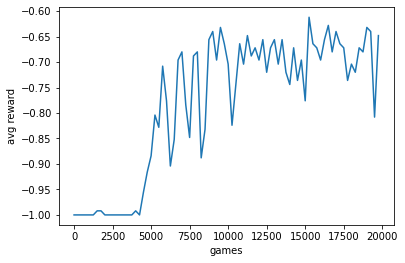

In [109]:
import matplotlib.pyplot as plt
length1=250
lst1 = env1.get_reward(player=1)
x_ticks = range(0, len(lst1), length1)
avg_reward1 = []
for i in range(len(lst1)//length1):
    avg_reward1.append(sum(lst1[i*length1:(i+1)*length1])/length1)
plt.plot(x_ticks, avg_reward1)
plt.xlabel(f'games')
plt.ylabel('avg reward')

Text(0, 0.5, 'avg loss')

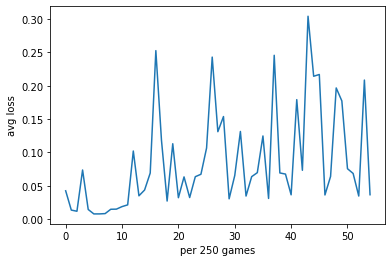

In [110]:
y_loss = env1.get_loss()
x_loss = range(0, len(y_loss))

plt.plot(x_loss, y_loss)
plt.xlabel(f'per 250 games')
plt.ylabel('avg loss')